# MultiTask Autoencoder Network is define below

**This notebook is to train 3D multitask autoencoder (MT-AE) for brain age estimation.**
**This code includes extensive augmentation and cosine learning-rate which help to improve the results.**

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv3D, BatchNormalization, ELU, add, MaxPooling3D, Flatten, Dense, Dropout, concatenate, UpSampling3D, Reshape, Conv3DTranspose)
from tensorflow.keras.regularizers import l2 as L2
import numpy as np

def ResidualBlock(x, features, paddingType='same', initType='he_uniform', regAmount=0.00005):
    shortcut = Conv3D(features, (1, 1, 1), strides=(1, 1, 1), padding=paddingType, kernel_initializer=initType, kernel_regularizer=L2(regAmount))(x)
    x = Conv3D(features, (3, 3, 3), padding=paddingType, kernel_initializer=initType, kernel_regularizer=L2(regAmount))(x)
    x = BatchNormalization()(x)
    x = ELU(alpha=1.0)(x)
    x = Conv3D(features, (3, 3, 3), padding=paddingType, kernel_initializer=initType, kernel_regularizer=L2(regAmount))(x)
    x = BatchNormalization()(x)
    x = add([shortcut, x])
    x = ELU(alpha=1.0)(x)
    return x

def Encoder(input_shape, features_list, paddingType='same', initType='he_uniform', regAmount=0.00005):
    inputs = Input(shape=input_shape + (1,), name='Input')
    x = inputs
    for features in features_list:
        x = ResidualBlock(x, features, paddingType, initType, regAmount)
        x = MaxPooling3D(pool_size=(2, 2, 2), padding=paddingType)(x)
    encoded = x
    return Model(inputs, encoded, name='Encoder')

def Decoder(encoded_shape, output_shape, features_list, paddingType='same', initType='he_uniform', regAmount=0.00005):
    inputs = Input(shape=encoded_shape[1:], name='EncodedInput')
    x = inputs
    for features in reversed(features_list):
        x = UpSampling3D(size=(2, 2, 2))(x)
        x = ResidualBlock(x, features, paddingType, initType, regAmount)
    x = Conv3D(output_shape[-1], (3, 3, 3), activation='sigmoid', padding=paddingType, kernel_initializer=initType)(x)
    x = Reshape(output_shape)(x)
    return Model(inputs, x, name='Decoder')

def MultiTaskAutoencoder(input_shape, features_list, paddingType='same', initType='he_uniform', regAmount=0.00005):
    encoder = Encoder(input_shape, features_list, paddingType, initType, regAmount)
    encoded_shape = encoder.output_shape

    decoder = Decoder(encoded_shape, input_shape + (1,), features_list, paddingType, initType, regAmount)
    
    # Additional branches for age and gender
    flat = Flatten()(encoder.output)
    dense = Dense(128, activation='relu')(flat)
    
    age_prediction = Dense(1, kernel_initializer=initType, kernel_regularizer=L2(regAmount), name='AgePrediction')(dense)
    gender_prediction = Dense(1, activation='sigmoid', kernel_initializer=initType, kernel_regularizer=L2(regAmount), name='GenderPrediction')(dense)
    
    inputs = encoder.input
    reconstruction = decoder(encoder.output)
    
    model = Model(inputs, [reconstruction, age_prediction, gender_prediction], name='MultiTaskAutoencoder')
    return model

input_shape = (96, 96, 96)
features_list = [8, 16, 32, 64, 128]

autoencoder_model = MultiTaskAutoencoder(input_shape, features_list)

autoencoder_model.summary()


Model: "MultiTaskAutoencoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 96, 96, 96,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d_1 (Conv3D)              (None, 96, 96, 96,   224         ['Input[0][0]']                  
                                8)                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 96, 96, 96,   32         ['conv3d_1[0][0]']               
 alization)                     8)                                             

## Checking the availability of GPUs..

In [2]:
import tensorflow as tf 
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Running code with extensive data augmentation

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, LearningRateScheduler
from tensorflow.keras.utils import Sequence
import tensorflow as tf
import os
import numpy as np
from scipy.ndimage import zoom, rotate
import random
from tensorflow.keras.models import load_model
import wandb
from wandb.integration.keras import WandbCallback
#from wandb.keras import WandbCallback

# Initialize W&B
wandb.init(
    project='multi-task-autoencoder_for_brain_age',  # Set your project name
    config={
        "epochs": 100,
        "batch_size": 8,
        "learning_rate": 0.001,
        "architecture": "multi-task-autoencoder"
    }
)

# Define a function for cosine decay learning rate schedule
def cosine_decay_schedule(initial_lr, epoch, total_epochs):
    lr = 0.5 * initial_lr * (1 + np.cos(np.pi * epoch / total_epochs))
    return lr

class DataGenerator(Sequence):
    def __init__(self, data_dir, participants, batch_size=8, dim=(96, 96, 96), shuffle=True, augment=False):
        self.data_dir = data_dir
        self.participants = participants
        self.batch_size = batch_size
        self.dim = dim
        self.shuffle = shuffle
        self.augment = augment
        self.indexes = np.arange(len(self.participants))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.floor(len(self.participants) / self.batch_size))
    
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        participants_temp = [self.participants.iloc[k] for k in indexes]
        X, y_age, y_gender = self.__data_generation(participants_temp)
        return {'Input': X}, {'Decoder': X, 'AgePrediction': y_age, 'GenderPrediction': y_gender}
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __data_generation(self, participants_temp):
        X = np.empty((self.batch_size, *self.dim, 1))
        y_age = np.empty((self.batch_size,))
        y_gender = np.empty((self.batch_size,))

        for i, participant in enumerate(participants_temp):
            file_path = os.path.join(self.data_dir, f'sub-{participant["participant_id"]}_preproc-quasiraw_T1w.npy')
            volume = np.squeeze(np.load(file_path))
            x = get_cropped_volume(volume)
            if self.augment:
                x = self.__augment_volume(x)
            X[i,] = x[..., np.newaxis]
            y_age[i] = participant["age"]
            y_gender[i] = 1 if participant["sex"] == "male" else 0
        
        return X, y_age, y_gender
    
    def __augment_volume(self, volume):
        if random.random() > 0.5:
            volume = np.flip(volume, axis=0)  # Flip along x-axis
        if random.random() > 0.5:
            volume = np.flip(volume, axis=1)  # Flip along y-axis
        if random.random() > 0.5:
            volume = np.flip(volume, axis=2)  # Flip along z-axis
        if random.random() > 0.5:
            volume = rotate(volume, angle=random.uniform(-20, 20), axes=(0, 1), reshape=False)
        if random.random() > 0.5:
            volume = zoom(volume, zoom=random.uniform(0.9, 1.1))
        if random.random() > 0.5:
            volume = self.__random_erasing(volume)
        
        # Resize back to the original dimensions
        volume = zoom(volume, np.array(self.dim) / np.array(volume.shape), order=1)
        return volume

    def __random_erasing(self, volume, p=0.5, s=(0.02, 0.4), r=(0.3, 3)):
        if random.random() > p:
            return volume
        area = volume.shape[0] * volume.shape[1] * volume.shape[2]
        target_area = random.uniform(*s) * area
        aspect_ratio = random.uniform(*r)

        h = int(round(np.sqrt(target_area * aspect_ratio)))
        w = int(round(np.sqrt(target_area / aspect_ratio)))
        d = int(round(np.sqrt(target_area / aspect_ratio)))
        
        if h < volume.shape[0] and w < volume.shape[1] and d < volume.shape[2]:
            x1 = random.randint(0, volume.shape[0] - h)
            y1 = random.randint(0, volume.shape[1] - w)
            z1 = random.randint(0, volume.shape[2] - d)
            volume[x1:x1+h, y1:y1+w, z1:z1+d] = 0
        return volume

def get_normalized(vol):
    norm_volume = (vol - vol.min()) / (vol.max() - vol.min())
    return norm_volume

def downsample_volume(volume, target_shape=(96, 96, 96)):
    zoom_factors = np.array(target_shape) / np.array(volume.shape)
    downsampled_volume = zoom(volume, zoom_factors, order=1)
    return downsampled_volume

def get_cropped_volume(val_sample):
    axial_sum = np.max(val_sample, axis=2)
    axial_msk = axial_sum > axial_sum.mean()
    coronal_sum = np.max(val_sample, axis=1)
    coronal_msk = coronal_sum > coronal_sum.mean()
    
    object_indices = np.argwhere(axial_msk)
    min_bounds = object_indices.min(axis=0)
    max_bounds = object_indices.max(axis=0) + 1
    x_min, x_max, y_min, y_max = min_bounds[0], max_bounds[0], min_bounds[1], max_bounds[1]

    object_indices = np.argwhere(coronal_msk)
    min_bounds = object_indices.min(axis=0)
    max_bounds = object_indices.max(axis=0) + 1
    _, _, z_min, z_max = min_bounds[0], max_bounds[0], min_bounds[1], max_bounds[1]
    
    x_min, x_max = get_fix_cords(x_min, x_max, 152)
    y_min, y_max = get_fix_cords(y_min, y_max, 188)
    z_min, z_max = get_fix_cords(z_min, z_max, 144)
    cropped_volume = val_sample[x_min:x_max, y_min:y_max, z_min:z_max]
    cropped_volume = downsample_volume(cropped_volume, target_shape=(96, 96, 96))
    normalized_volume = get_normalized(cropped_volume)
    
    return normalized_volume

def get_fix_cords(xmn, xmx, fvalue):
    c_point = xmn + (xmx - xmn) / 2
    nx_min = int(c_point - fvalue / 2)
    nx_max = int(c_point + fvalue / 2)
    return nx_min, nx_max

# Update the paths
train_tsv_path = r'C:\Users\User\Documents\Dataset\Brain Age\train\train_labels\participants.tsv'
train_data_dir = r'C:\Users\User\Documents\Dataset\Brain Age\train\train_quasiraw'
train_participants = pd.read_csv(train_tsv_path, sep='\t')

# Bin the ages into discrete categories for stratification
bins = [0, 18, 25, 35, 50, 100]  # Define age bins
labels = ['0-18', '19-25', '26-35', '36-50', '50+']  # Labels for the bins
train_participants['age_bin'] = pd.cut(train_participants ['age'], bins=bins, labels=labels, right=False)

# Check the distribution in each bin
print(train_participants['age_bin'].value_counts())

# Split the dataset into training and validation sets (90% train, 10% validation)
train_participants, val_participants = train_test_split(
    train_participants,
    test_size=0.1,
    random_state=42,
    stratify=train_participants['age_bin']  # Stratify by the age bins
)


# Drop the 'age_bin' column after splitting if it's not needed
train_participants = train_participants.drop(columns=['age_bin'])
val_participants = val_participants.drop(columns=['age_bin'])


# Create data generators with the updated splits
train_generator = DataGenerator(train_data_dir, train_participants, batch_size=4, dim=(96, 96, 96), shuffle=True, augment=True)
val_generator = DataGenerator(train_data_dir, val_participants, batch_size=2, dim=(96, 96, 96), shuffle=False, augment=False)


# Compile the model with multiple loss functions and weights
autoencoder_model.compile(optimizer='adam', 
                          loss={'Decoder': 'mse', 'AgePrediction': 'mse', 'GenderPrediction': 'binary_crossentropy'}, 
                          loss_weights={'Decoder': 0.1, 'AgePrediction': 0.75, 'GenderPrediction': 0.15},
                          metrics={'AgePrediction': 'mae', 'GenderPrediction': 'accuracy'})

# Define callbacks
early_stopping = EarlyStopping(monitor='val_AgePrediction_mae', patience=50, restore_best_weights=True)
checkpoint = ModelCheckpoint('./test_weights/MTL_autoencoder_best.h5', monitor='val_loss', save_best_only=True, mode='min')
tensorboard = TensorBoard(log_dir='./test_weights/logs_multi_task_autoencoder_v4.0')

# Initial learning rate
initial_learning_rate = 0.001

# Learning rate scheduler
lr_scheduler = LearningRateScheduler(lambda epoch: cosine_decay_schedule(initial_learning_rate, epoch, 100))

# Train the model
history = autoencoder_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=[early_stopping, checkpoint, tensorboard, lr_scheduler, WandbCallback()],
)

# Save the trained model
autoencoder_model.save('./test_weights/MTL_autoencoder_final_weights.h5')

# Finish W&B run
wandb.finish()


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ussman (ussman-Stanford University). Use `wandb login --relogin` to force relogin


age_bin
19-25    1632
0-18      634
26-35     517
50+       305
36-50     139
Name: count, dtype: int64


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/100
 13/726 [..............................] - ETA: 9:04 - loss: 1573.6158 - Decoder_loss: 0.2385 - AgePrediction_loss: 2097.4937 - GenderPrediction_loss: 2.1900 - AgePrediction_mae: 28.4152 - GenderPrediction_accuracy: 0.5000

KeyboardInterrupt: 

## Code for inference/testing

1/1 [==============================] - 0s 16ms/step
Overall - MSE: 20.47 (SD: 668.25), MAE: 2.95 (SD: 13.06), RMSE: 4.52 (SD: 13.06), R2: 0.87, MAPE: 0.13
Male - MSE: 20.51 (SD: 580.64), MAE: 2.97 (SD: 11.77), RMSE: 4.53 (SD: 11.77), R2: 0.85, MAPE: 0.14
Female - MSE: 20.41 (SD: 740.89), MAE: 2.93 (SD: 14.32), RMSE: 4.52 (SD: 14.32), R2: 0.89, MAPE: 0.11


ValueError: x must have 2 or fewer dimensions

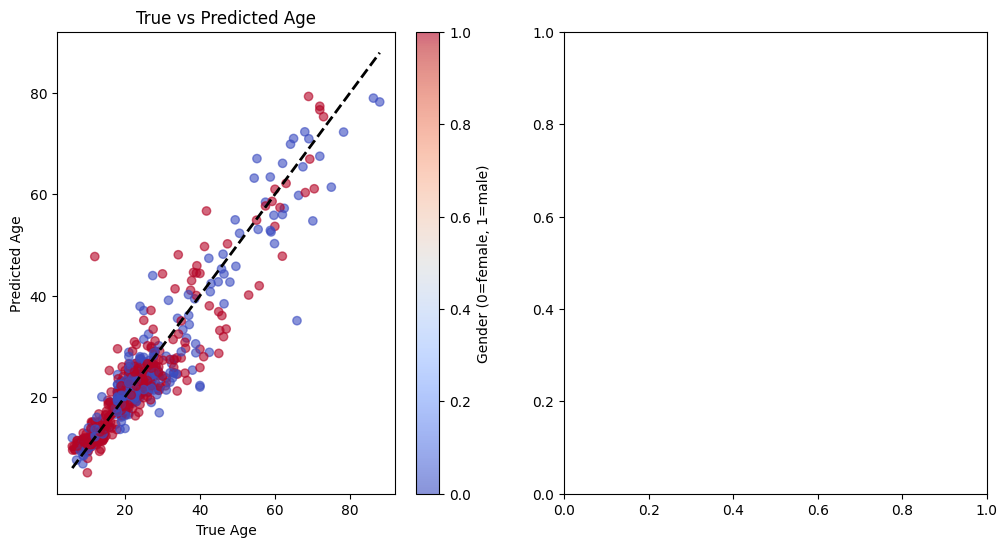

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from tensorflow.keras.models import load_model

def preprocess_volume(volume):
    x = get_cropped_volume(volume)
    x = x[np.newaxis, ..., np.newaxis]  # Add batch and channel dimensions
    return x

def load_volume(file_path):
    volume = np.squeeze(np.load(file_path))
    return volume

def inference(model, file_path):
    volume = load_volume(file_path)
    processed_volume = preprocess_volume(volume)
    reconstruction, age_prediction, gender_prediction = model.predict({'Input': processed_volume})
    return reconstruction, age_prediction[0], gender_prediction[0]

def compute_metrics(true_values, pred_values):
    mse = mean_squared_error(true_values, pred_values)
    mae = mean_absolute_error(true_values, pred_values)
    rmse = np.sqrt(mse)
    r2 = r2_score(true_values, pred_values)
    mape = mean_absolute_percentage_error(true_values, pred_values)
    return mse, mae, rmse, r2, mape

def compute_sd(values):
    return np.std(values)

# Load the model
model_path = 'autoencoder_best_weights_test_v4.h5'
model = load_model(model_path)

# Load participants information
data_dir = r'C:\Users\User\Documents\Dataset\Brain Age\val\val_quasiraw'
participants_tsv = r'C:\Users\User\Documents\Dataset\Brain Age\val\val_labels\participants.tsv'
participants = pd.read_csv(participants_tsv, sep='\t')

# Initialize lists to store true and predicted values
true_ages = []
pred_ages = []
genders = []
pred_genders = []

# Perform inference on all samples
batch_size = 4
for start_idx in range(0, len(participants), batch_size):
    end_idx = min(start_idx + batch_size, len(participants))
    batch_participants = participants.iloc[start_idx:end_idx]
    
    for index, row in batch_participants.iterrows():
        participant_id = row['participant_id']
        age = row['age']
        gender = row['sex']  # 'male' or 'female'
        file_path = os.path.join(data_dir, f'sub-{participant_id}_preproc-quasiraw_T1w.npy')

        reconstruction, age_prediction, gender_prediction = inference(model, file_path)

        true_ages.append(age)
        pred_ages.append(age_prediction)
        genders.append(1 if gender == 'male' else 0)
        pred_genders.append(gender_prediction)

# Convert to numpy arrays
true_ages = np.array(true_ages)
pred_ages = np.array(pred_ages)
genders = np.array(genders)
pred_genders = np.array(pred_genders)

# Compute metrics for overall samples
overall_metrics = compute_metrics(true_ages, pred_ages)
overall_mse_sd = compute_sd((true_ages - pred_ages)**2)
overall_mae_sd = compute_sd(np.abs(true_ages - pred_ages))
overall_rmse_sd = compute_sd(np.sqrt((true_ages - pred_ages)**2))

# Compute metrics for male samples
male_mask = genders == 1
male_metrics = compute_metrics(true_ages[male_mask], pred_ages[male_mask])
male_mse_sd = compute_sd((true_ages[male_mask] - pred_ages[male_mask])**2)
male_mae_sd = compute_sd(np.abs(true_ages[male_mask] - pred_ages[male_mask]))
male_rmse_sd = compute_sd(np.sqrt((true_ages[male_mask] - pred_ages[male_mask])**2))

# Compute metrics for female samples
female_mask = genders == 0 
female_metrics = compute_metrics(true_ages[female_mask], pred_ages[female_mask])
female_mse_sd = compute_sd((true_ages[female_mask] - pred_ages[female_mask])**2)
female_mae_sd = compute_sd(np.abs(true_ages[female_mask] - pred_ages[female_mask]))
female_rmse_sd = compute_sd(np.sqrt((true_ages[female_mask] - pred_ages[female_mask])**2))

# Print the results
print(f'Overall - MSE: {overall_metrics[0]:.2f} (SD: {overall_mse_sd:.2f}), MAE: {overall_metrics[1]:.2f} (SD: {overall_mae_sd:.2f}), RMSE: {overall_metrics[2]:.2f} (SD: {overall_rmse_sd:.2f}), R2: {overall_metrics[3]:.2f}, MAPE: {overall_metrics[4]:.2f}')
print(f'Male - MSE: {male_metrics[0]:.2f} (SD: {male_mse_sd:.2f}), MAE: {male_metrics[1]:.2f} (SD: {male_mae_sd:.2f}), RMSE: {male_metrics[2]:.2f} (SD: {male_rmse_sd:.2f}), R2: {male_metrics[3]:.2f}, MAPE: {male_metrics[4]:.2f}')
print(f'Female - MSE: {female_metrics[0]:.2f} (SD: {female_mse_sd:.2f}), MAE: {female_metrics[1]:.2f} (SD: {female_mae_sd:.2f}), RMSE: {female_metrics[2]:.2f} (SD: {female_rmse_sd:.2f}), R2: {female_metrics[3]:.2f}, MAPE: {female_metrics[4]:.2f}')

# Visualization
def plot_distributions(true_ages, pred_ages, genders, pred_genders):
    plt.figure(figsize=(12, 6))

    # Age prediction distribution
    plt.subplot(1, 2, 1)
    plt.scatter(true_ages, pred_ages, c=genders, cmap='coolwarm', alpha=0.6)
    plt.plot([true_ages.min(), true_ages.max()], [true_ages.min(), true_ages.max()], 'k--', lw=2)
    plt.xlabel('True Age')
    plt.ylabel('Predicted Age')
    plt.title('True vs Predicted Age')
    plt.colorbar(label='Gender (0=female, 1=male)')

    # Gender prediction distribution
    plt.subplot(1, 2, 2)
    plt.hist([pred_genders[genders == 0], pred_genders[genders == 1]], bins=20, stacked=True, color=['r', 'b'], label=['Female', 'Male'])
    plt.xlabel('Predicted Gender Probability')
    plt.ylabel('Frequency')
    plt.title('Gender Prediction Distribution')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_distributions(true_ages, pred_ages, genders, pred_genders)

# Error Analysis
def error_analysis(true_ages, pred_ages):
    errors = true_ages - pred_ages
    plt.figure(figsize=(10, 5))

    plt.hist(errors, bins=30, color='purple', alpha=0.7)
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    plt.title('Age Prediction Error Distribution')
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.scatter(true_ages, errors, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('True Age')
    plt.ylabel('Prediction Error')
    plt.title('Error Analysis')
    plt.show()

error_analysis(true_ages, pred_ages)

# Save Results
results_df = pd.DataFrame({
    'True_Age': true_ages,
    'Predicted_Age': pred_ages,
    'True_Gender': genders,
    'Predicted_Gender': pred_genders
})

results_df.to_csv('inference_results_v4.csv', index=False)


Overall - MSE: 20.47 (SD: 668.25), MAE: 2.95 (SD: 13.06), RMSE: 4.52 (SD: 13.06), R2: 0.87, MAPE: 0.13
Male - MSE: 20.51 (SD: 580.64), MAE: 2.97 (SD: 11.77), RMSE: 4.53 (SD: 11.77), R2: 0.85, MAPE: 0.14
Female - MSE: 20.41 (SD: 740.89), MAE: 2.93 (SD: 14.32), RMSE: 4.52 (SD: 14.32), R2: 0.89, MAPE: 0.11


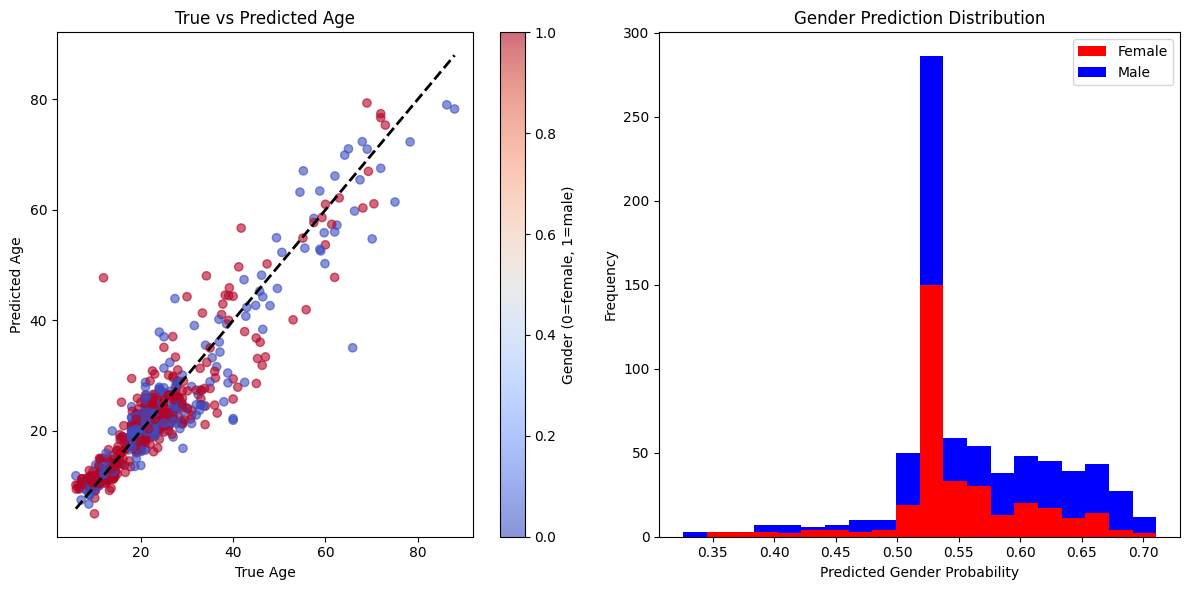

In [8]:

# Compute metrics for overall samples
overall_metrics = compute_metrics(true_ages, pred_ages)
overall_mse_sd = compute_sd((true_ages - pred_ages)**2)
overall_mae_sd = compute_sd(np.abs(true_ages - pred_ages))
overall_rmse_sd = compute_sd(np.sqrt((true_ages - pred_ages)**2))

# Compute metrics for male samples
male_mask = genders == 1
male_metrics = compute_metrics(true_ages[male_mask], pred_ages[male_mask])
male_mse_sd = compute_sd((true_ages[male_mask] - pred_ages[male_mask])**2)
male_mae_sd = compute_sd(np.abs(true_ages[male_mask] - pred_ages[male_mask]))
male_rmse_sd = compute_sd(np.sqrt((true_ages[male_mask] - pred_ages[male_mask])**2))

# Compute metrics for female samples
female_mask = genders == 0 
female_metrics = compute_metrics(true_ages[female_mask], pred_ages[female_mask])
female_mse_sd = compute_sd((true_ages[female_mask] - pred_ages[female_mask])**2)
female_mae_sd = compute_sd(np.abs(true_ages[female_mask] - pred_ages[female_mask]))
female_rmse_sd = compute_sd(np.sqrt((true_ages[female_mask] - pred_ages[female_mask])**2))

# Print the results
print(f'Overall - MSE: {overall_metrics[0]:.2f} (SD: {overall_mse_sd:.2f}), MAE: {overall_metrics[1]:.2f} (SD: {overall_mae_sd:.2f}), RMSE: {overall_metrics[2]:.2f} (SD: {overall_rmse_sd:.2f}), R2: {overall_metrics[3]:.2f}, MAPE: {overall_metrics[4]:.2f}')
print(f'Male - MSE: {male_metrics[0]:.2f} (SD: {male_mse_sd:.2f}), MAE: {male_metrics[1]:.2f} (SD: {male_mae_sd:.2f}), RMSE: {male_metrics[2]:.2f} (SD: {male_rmse_sd:.2f}), R2: {male_metrics[3]:.2f}, MAPE: {male_metrics[4]:.2f}')
print(f'Female - MSE: {female_metrics[0]:.2f} (SD: {female_mse_sd:.2f}), MAE: {female_metrics[1]:.2f} (SD: {female_mae_sd:.2f}), RMSE: {female_metrics[2]:.2f} (SD: {female_rmse_sd:.2f}), R2: {female_metrics[3]:.2f}, MAPE: {female_metrics[4]:.2f}')

# Visualization
def plot_distributions(true_ages, pred_ages, genders, pred_genders):
    plt.figure(figsize=(12, 6))

    # Age prediction distribution
    plt.subplot(1, 2, 1)
    plt.scatter(true_ages, pred_ages, c=genders, cmap='coolwarm', alpha=0.6)
    plt.plot([true_ages.min(), true_ages.max()], [true_ages.min(), true_ages.max()], 'k--', lw=2)
    plt.xlabel('True Age')
    plt.ylabel('Predicted Age')
    plt.title('True vs Predicted Age')
    plt.colorbar(label='Gender (0=female, 1=male)')

    # Gender prediction distribution
    plt.subplot(1, 2, 2)
    plt.hist([pred_genders[genders == 0].flatten(), pred_genders[genders == 1].flatten()], bins=20, stacked=True, color=['r', 'b'], label=['Female', 'Male'])
    plt.xlabel('Predicted Gender Probability')
    plt.ylabel('Frequency')
    plt.title('Gender Prediction Distribution')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_distributions(true_ages, pred_ages, genders, pred_genders)

# Error Analysis
def error_analysis(true_ages, pred_ages):
    errors = true_ages - pred_ages
    plt.figure(figsize=(10, 5))

    plt.hist(errors, bins=30, color='purple', alpha=0.7)
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    plt.title('Age Prediction Error Distribution')
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.scatter(true_ages, errors, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('True Age')
    plt.ylabel('Prediction Error')
    plt.title('Error Analysis')
    plt.show()
